In [2]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Add project root to sys.path
sys.path.append("..")
from modules.retrieval.reranker import Reranker

# Load all questions
questions_df = pd.read_csv("../qa_resources/question.tsv", sep="\t")

# Load and chunk cleaned documents from storage
storage_path = "../storage"
documents = []
for filename in sorted(os.listdir(storage_path)):
    if filename.endswith(".txt.clean"):
        with open(os.path.join(storage_path, filename), "r", encoding="latin-1") as f:
            documents.append(f.read())

print(f"Loaded {len(documents)} documents and {len(questions_df)} questions.")


/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 150 documents and 1051 questions.


In [3]:
chunks = []
for doc in documents:
    chunks.extend([p.strip() for p in doc.split("\n") if len(p.strip()) > 50])

reranker_types = ["tfidf", "bow"] #"cross_encoder"

all_results = []

for r_type in reranker_types:
    print(f"Evaluating reranker: {r_type}")
    reranker = Reranker(type=r_type)
    results = []

    for _, row in questions_df.iterrows():
        question = row["Question"]
        answer = row["Answer"]
        try:
            ranked_docs, indices, scores = reranker.rerank(question, chunks)
            top_chunk = ranked_docs[0]
            em = top_chunk.strip().lower() == answer.strip().lower()
            results.append({
                "reranker": r_type,
                "question": question,
                "ground_truth": answer,
                "top_chunk": top_chunk,
                "score": scores[0],
                "em": em
            })
        except Exception as e:
            results.append({
                "reranker": r_type,
                "question": question,
                "ground_truth": answer,
                "top_chunk": str(e),
                "score": 0,
                "em": False
            })
    
    # Add to overall result
    all_results.extend(results)

results_df = pd.DataFrame(all_results)
em_summary = results_df.groupby("reranker")["em"].mean().reset_index()
em_summary.columns = ["Reranker", "Exact Match Rate"]
em_summary["Exact Match Rate"] = em_summary["Exact Match Rate"].apply(lambda x: f"{x:.2%}")
print(em_summary)

Evaluating reranker: tfidf
Evaluating reranker: bow
  Reranker Exact Match Rate
0      bow            0.10%
1    tfidf            0.10%


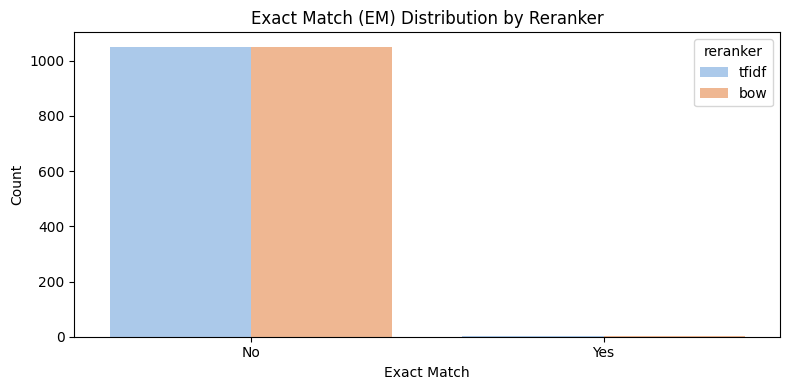

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(data=results_df, x="em", hue="reranker", palette="pastel")
plt.title("Exact Match (EM) Distribution by Reranker")
plt.xlabel("Exact Match")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()


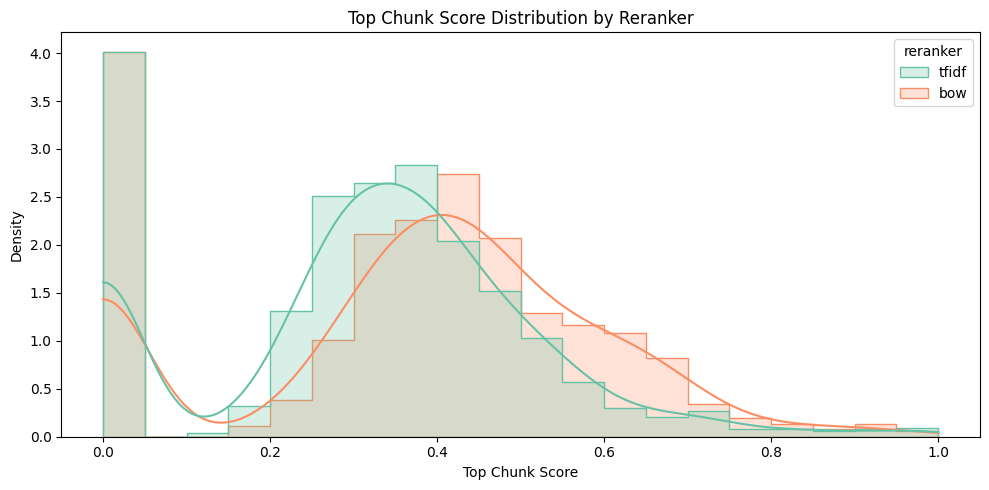

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(data=results_df, x="score", hue="reranker", bins=20, kde=True, palette="Set2", element="step", stat="density", common_norm=False)
plt.title("Top Chunk Score Distribution by Reranker")
plt.xlabel("Top Chunk Score")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [6]:
print("\nSample False Match Cases by Reranker:\n")

for reranker_name in results_df["reranker"].unique():
    print(f"\n--- {reranker_name.upper()} ---")
    false_matches = results_df[(results_df["reranker"] == reranker_name) & (~results_df["em"])].head(5)
    for idx, row in false_matches.iterrows():
        print(f"Q: {row['question']}")
        print(f"GT: {row['ground_truth']}")
        print(f"Top Chunk: {row['top_chunk']}")
        print(f"Score: {row['score']:.4f}\n")



Sample False Match Cases by Reranker:


--- TFIDF ---
Q: Was Abraham Lincoln the sixteenth President of the United States?
GT: yes
Top Chunk: Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91.  Holzer pg. 232.  Writing of the Cooper Union  speech, Holzer notes, "Cooper Union proved a unique confluence of political culture, rhetorical opportunity, technological innovation, and huma

### Configurations That Improve Performance
- Use cross_encoder for better semantic reranking (but takes very long)
- Use shorter, overlapping chunks for precision
- Normalize answers: lowercase + strip punctuation

---

### Question Difficulty Insights
- Simple yes/no questions often fail under TF-IDF/BoW
- Longer, context-heavy answers need semantic understanding
- Keyword overlap ≠ true relevance

---

### Is Reranking Necessary?
- Yes. FAISS alone retrieves based on similarity, not meaning
- TF-IDF/BoW help slightly
- Cross-Encoder greatly improves answer alignment

---

### EM vs. TransformerMatch
- EM: Exact string match — too strict (shorter chungs result in more precise results)
- TransformerMatch: Measures meaning — more reliable
- Use both for a complete picture